In [1]:
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.simulator import Simulator, generate_sim_config
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
import numpy as np
from deorbit.observer import Observer
from deorbit.utils.constants import EARTH_RADIUS
from deorbit.utils.plotting import plot_heatmap


In [2]:
save_path = "eg/EKF_example_3D/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

np.random.seed(0)
start_direction = np.random.normal(size=2)
start_direction /= np.linalg.norm(start_direction)
if sim_data is None or sim_config is None:
    rollout_sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 0, *(start_direction * 7820))),
        noise_types = {"gaussian": {"noise_strength": 0.001}, "impulse": {"impulse_strength": 0.005, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = rollout_sim.gather_data()
    sim_config = rollout_sim.export_config()
    rollout_sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


100%|██████████| 129/129 [00:06<00:00, 19.79it/s]


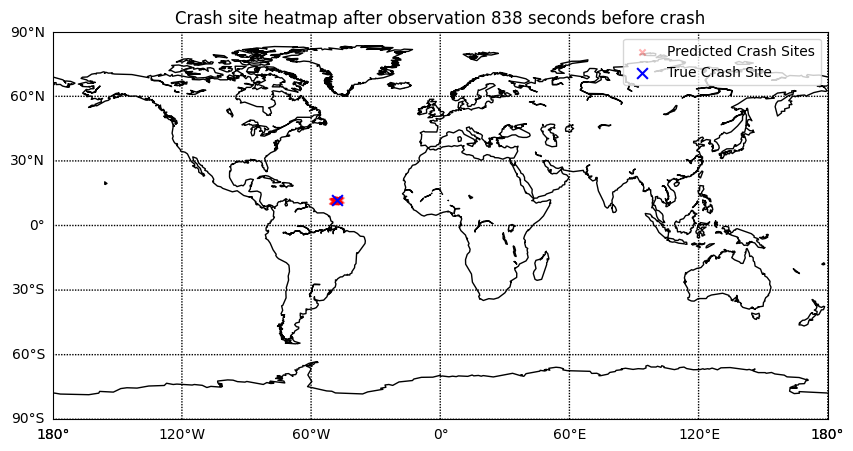

pos_std=0.0001
total std: 42946.5896519281


100%|██████████| 129/129 [00:06<00:00, 20.41it/s]


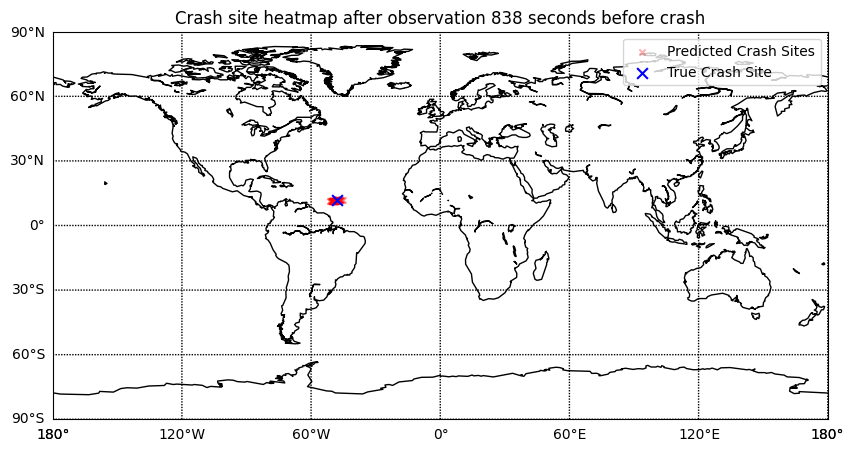

pos_std=0.0005
total std: 65630.57532007786


100%|██████████| 129/129 [00:06<00:00, 20.55it/s]


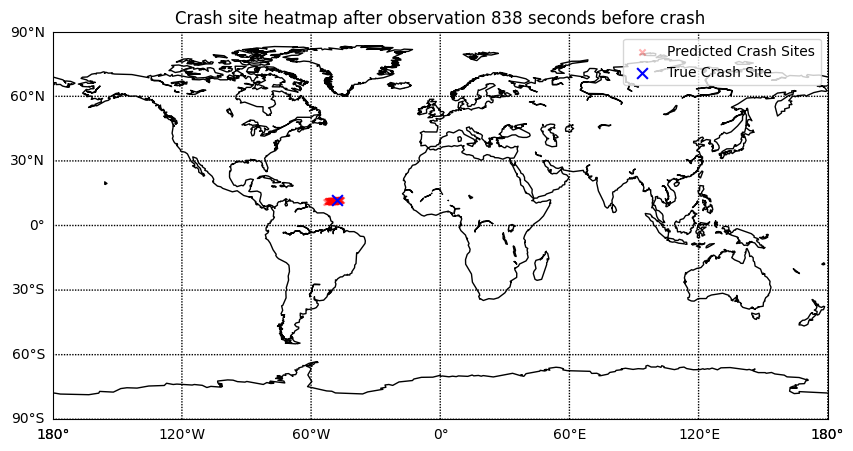

pos_std=0.001
total std: 84767.24828982085


100%|██████████| 129/129 [00:06<00:00, 20.50it/s]


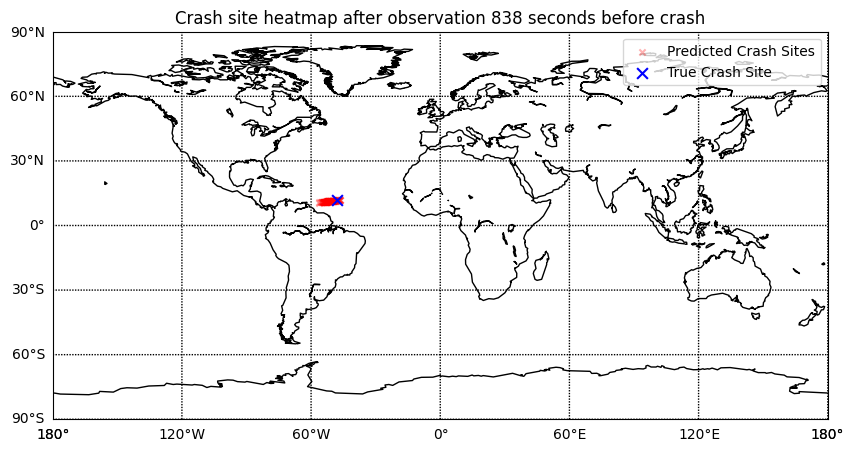

pos_std=0.002
total std: 129459.71861246032


100%|██████████| 129/129 [00:06<00:00, 18.74it/s]


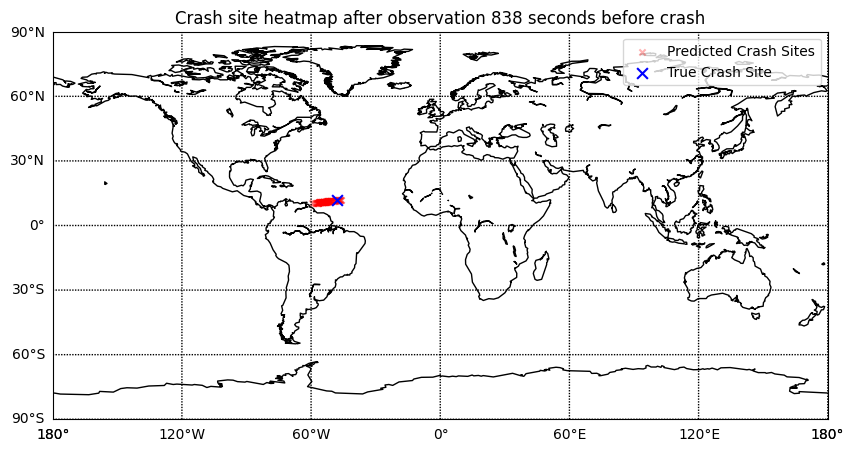

pos_std=0.003
total std: 179019.824766272


100%|██████████| 129/129 [00:06<00:00, 19.53it/s]


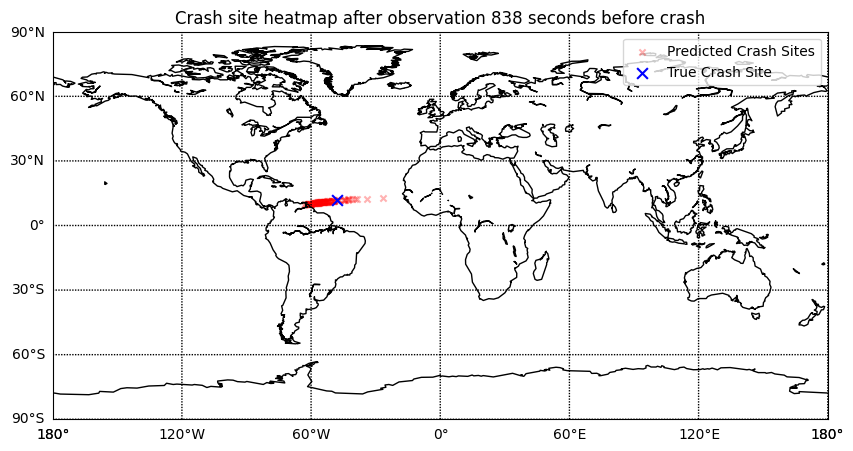

pos_std=0.005
total std: 350639.83646475524


100%|██████████| 129/129 [00:06<00:00, 19.00it/s]


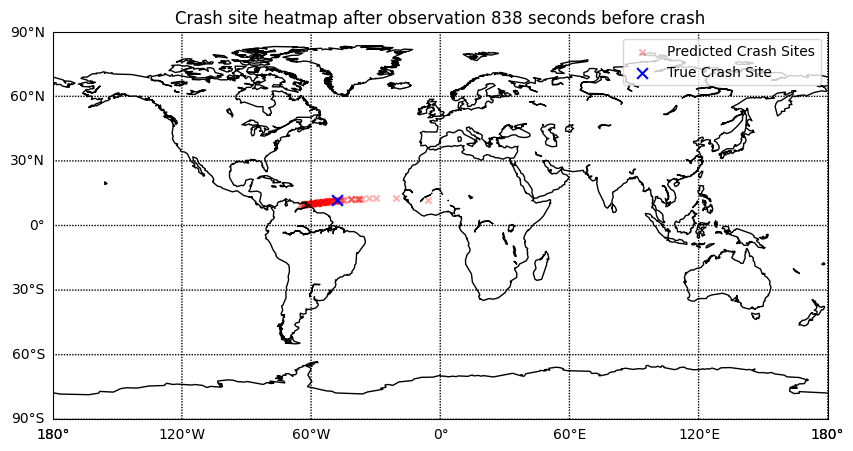

pos_std=0.006
total std: 487542.8600967653


100%|██████████| 129/129 [00:06<00:00, 19.06it/s]


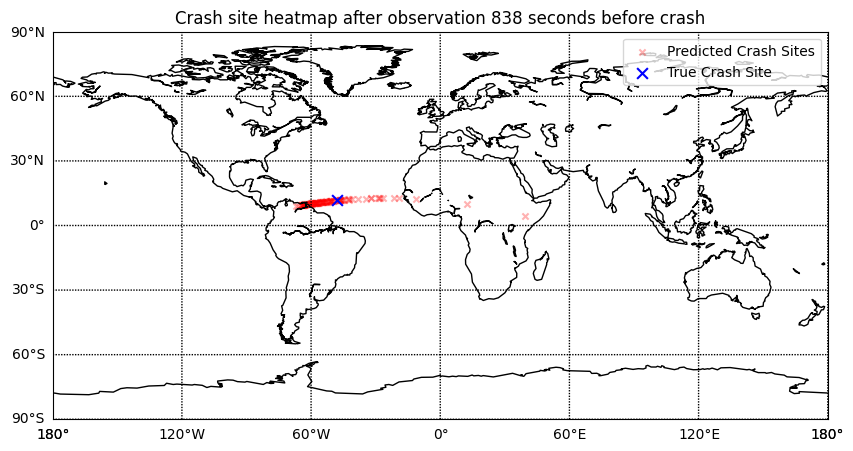

pos_std=0.007
total std: 762433.0622681138


100%|██████████| 129/129 [00:06<00:00, 19.17it/s]


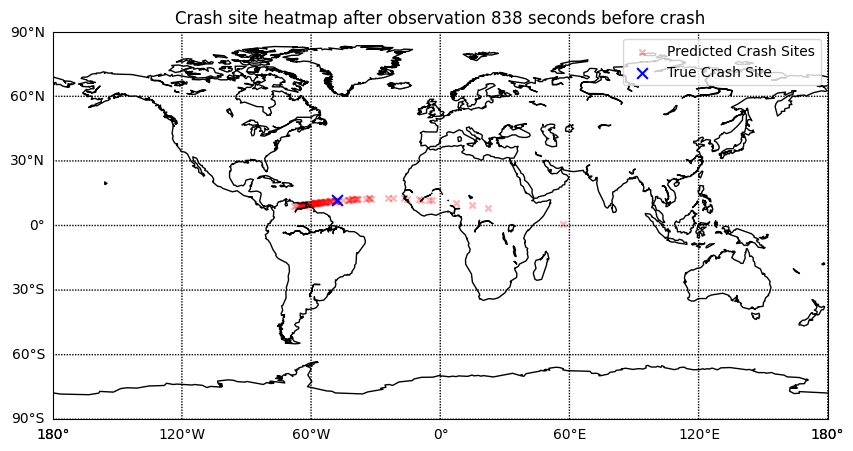

pos_std=0.008
total std: 1224543.8857067723


100%|██████████| 129/129 [00:06<00:00, 18.65it/s]


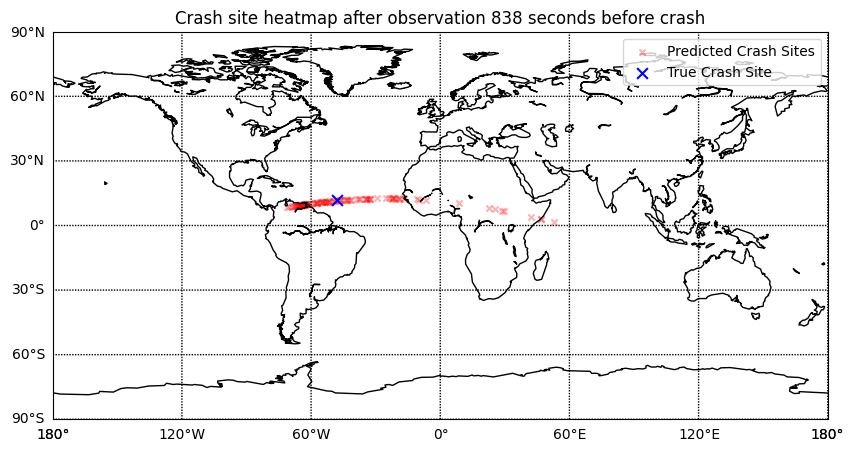

pos_std=0.01
total std: 1741935.9938321298


In [11]:
#initialising observer class with sim data
final_std = {}
position_std_per_distance = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.01]
for pos_std in position_std_per_distance:
    np.random.seed(4)
    obs = Observer(number_of_radars=200, dim=3, radar_position_std_per_distance=pos_std)

    sim_states = sim_data.state_array()
    sim_times = sim_data.times

    obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)

    observation_times = obs.observed_times
    observation_states = obs.observed_states
    observed_covariances = obs.observed_covariances

    observations = (observation_states, observation_times)

    # Define process and measurement noise covariance matrices, think this noise should be alot bigger
    Q = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])#process noise
    P = np.eye(sim_data.state_array().shape[1]) #error covariance matrix - represents uncertainty in state estimation

    # Measurement matrix H (assuming all states are measured directly??????) -- for now
    H = np.zeros((sim_data.state_array().shape[1], sim_data.state_array().shape[1]))
    H[0, 0] = 1
    H[1, 1] = 1

    dt = sim_config.simulation_method_kwargs.time_step

    #initialising 3D EKF
    ekf = EKF(dim=3)

    estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=observed_covariances, P=P, H=H)

    observations_to_check = [-2]
    crashes, crash_times = plot_heatmap(sim_states, sim_times, estimated_traj, estimated_times, observations_to_check, observation_times, uncertainties)
    total_std = np.mean(np.std(crashes[0], axis=0))
    print(f"{pos_std=}")
    print(f"total std: {total_std}")
    final_std[pos_std] = total_std

Text(0, 0.5, 'Standard deviation of crash points (m)')

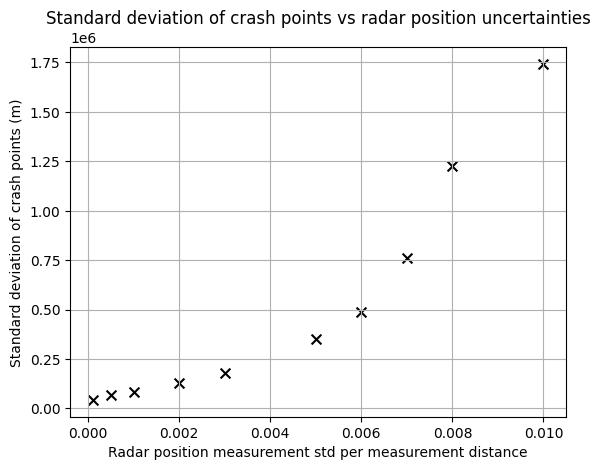

In [23]:
fig, ax = plt.subplots()

ax.grid()
ax.scatter(final_std.keys(), final_std.values(), label="Total std", marker="x", color="k", s=50)
ax.set_title(f"Standard deviation of crash points vs radar position uncertainties")
ax.set_xlabel("Radar position measurement std per measurement distance")
ax.set_ylabel("Standard deviation of crash points (m)")